In [1]:
import os
import matplotlib.pyplot as plt

from lvmdrp.utils.examples import get_frames_metadata
from lvmdrp.core import rss

from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

/home/mejia/Downloads/home/mejia/.local/bin/miniconda3/envs/lvmdrp/lib/python3.8/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = os.path.join("data")
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.{ext}")

# extract metadata
frames_table = get_frames_metadata(path=data_path)
# group by imagetyp, camera and exptime
frames_table = frames_table.group_by(["imagetyp", "spec", "camera", "expnum", "exptime"])
# define groups and unique categories in those groups
frames_groups = frames_table.groups
unique_groups = frames_groups.keys

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/frames_table.pkl'


In [3]:


fiberflats = frames_groups[(unique_groups["imagetyp"]=="flat")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00001002")]
arcs = frames_groups[(unique_groups["imagetyp"]=="arc")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00010001")]

CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}

ised = 300
coad = 10

for fiberflat_frame, arc_frame in zip(fiberflats, arcs):
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    
    wave_range = CHANNEL_WL[arc_camera]

    imageMethod.extractSpec_drp(
        in_image=out_path.format(kind="carc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_trace=out_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=4, plot=1, parallel="auto"
    )

    rssMethod.autoPixWaveMap_drp(
        in_arc=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_pixwave=out_path.format(kind="pixwave", camera=arc_camera, expnum=arc_expnum, ext="txt"),
        elements="Ne,Hg", ref_fiber=ised, coadd_fibers=coad, wave_range=",".join(map(str, wave_range))
    )

    rssMethod.detWaveSolution_drp(
        in_arc=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_wave=out_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_lsf=out_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_ref_lines=out_path.format(kind="pixwave", camera=arc_camera, expnum=arc_expnum, ext="txt"),
        ref_fiber=ised, poly_dispersion=-2, poly_fwhm='-2,-1', verbose=1
    )

    rssMethod.createPixTable_drp(
        in_rss=os.path.join(output_path, f"lvm-xarc-{arc_camera}-{arc_expnum}.fits"),
        out_rss=os.path.join(output_path, f"lvm-warc-{arc_camera}-{arc_expnum}.fits"),
        arc_wave=os.path.join(output_path, f"lvm-wave-{arc_camera}-{arc_expnum}.fits"),
        arc_fwhm=os.path.join(output_path, f"lvm-lsf-{arc_camera}-{arc_expnum}.fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=os.path.join(output_path, f"lvm-warc-{arc_camera}-{arc_expnum}.fits"),
        out_rss=os.path.join(output_path, f"lvm-harc-{arc_camera}-{arc_expnum}.fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

In [4]:
rssMethod.joinSpecChannels(
    in_rss=[out_path.format(kind="harc", camera=arc_frame["camera"], expnum=arc_frame["expnum"], ext="fits") for arc_frame in arcs],
    out_rss=out_path.format(kind="jarc", camera="sp1", expnum=arc_expnum, ext="fits"),
    parallel="auto"
)

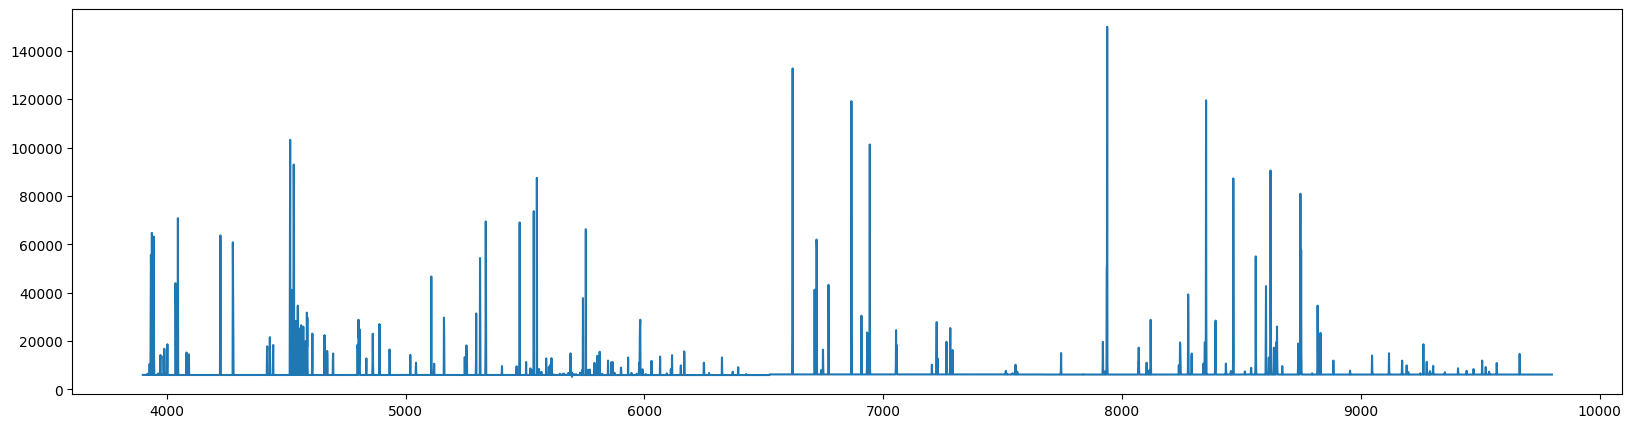

In [5]:
jarc = rss.RSS()
jarc.loadFitsData(out_path.format(kind="jarc", camera="sp1", expnum=arc_expnum, ext="fits"))

plt.figure(figsize=(20,5))
plt.plot(jarc._wave, jarc._data[ised])